In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

# Tutorial for pySTAR 
Author: Dimitrios Fardis  
Maintainer: Dimitrios Fardis  
Updated: 09/23/2024

**Python Symbolic regression Through Algebraic Representations** (pySTAR) provides tools for generating mathematical (symbolic) models that best fit some input data (Sarwar, 2022). The pySTAR toolbox allows for the definition of the form of the surrogate model and the regression parameter values simultaneously.

## References
Sarwar, O. 2022, Algorithms for Interpretable High-Dimensional Regression, Carnegie Mellon University.

## 1. Installation

The **pySTAR** toolbox is installed by default as part of IDAES. For instructions on installing IDAES, see the [online documentation](https://idaes-pse.readthedocs.io/en/stable/).

## 2. Generating surrogate models with pySTAR

The pySTAR framework currently provides tools for generating surrogates that allow for seven types of operators in the mathematical expression. Four of the operators are binary operators:

- Addition (+)
- Substraction (-)
- Multiplication (*)
- Division (/)

The rest three operators are unary:
- Square root (^0.5)
- Logarithm (log)
- Exponential (exp)

### 3. Generating symbolic regression models for the outputs of a leaching process

As an example, let us generate a surrogate model for an output of the leaching process of a critical minerals recovery plant. During this process, various critical minerals are extracted from ores using sulfuric acid. Two streams enter the leaching process of the plant; a solids stream that contain the ores and a liquid stream with an aqueous solution of sulfuric acid. The outlets of leaching are two; a solids waste stream and a liquid stream that is enriched with the critical minerals in ionic form.

The input variables of this process are two; the molar concentration of sulfuric acid in the liquid inlet and the mass flowrate of the solids stream. The output variables of the process are thirty. All the variables, as well as ten datapoints, can be found in the csv file '3_4_simulation_data_{k}.csv'. The combined dataset (training and testing points) have been min-max scaled between the numbers 3 and 4. The pySTAR algorithm performs better when the data are scaled in this way. Scaling between 0 and 1 would cause problems with the division operation.

As an example, let us generate a surrogate model for the volumetric flowrate of the liquid outlet which is an output of the leaching process, named 'liquid_outlet_flow_vol'. 

### 3.1. Training the model

#### Step 1: Import the needed packages and the symbolic regression tool

In [2]:
import numpy as np
import time
from pyomo.opt import SolverFactory
import os
import csv
import hashlib
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

from STEP_1 import *
from STEP_2 import *
from STEP_3 import *

#### Step 2: Read the txt file with the name of the output

The txt file 'output.txt' contains the name of the output variable. In this example, the name of the output is 'liquid_outlet_flow_vol'.

In [3]:
# Open the txt file in read mode
with open('output.txt', 'r') as file:
    # Read the contents of the file
    content = file.read().strip()
# Convert the contents to an integer and assign to model
output_name = content
# Print the model type to verify
print('Output=',output_name)

Output= liquid_outlet_flow_vol


#### Step 3: Read the csv file with our data using pandas
We also print the 10 points of our dataset. The variables 'liquid_inlet_conc_mol_comp_H2SO4' and 'solid_inlet_flow_mass' are the inputs of the leaching process and the variable 'liquid_outlet_flow_vol' is an output.

In [4]:
# read in our csv data
columns = ['liquid_inlet_conc_mol_comp_H2SO4','solid_inlet_flow_mass',
           f'{output_name}'] 

k=10
print('Training points=',k)            
df = pd.read_csv(f'3_4_simulation_data_{k}.csv', usecols=columns)

# separate the data into inputs and outputs
inputs = ['liquid_inlet_conc_mol_comp_H2SO4','solid_inlet_flow_mass']

outputs= [f'{output_name}']

dfin = df[inputs]
dfout = df[outputs]
print('Inputs:')
print(dfin)
print('Output:')
print(dfout)

#Convert the pandas dataframes to numpy arrays
X = dfin.to_numpy()
y = dfout.to_numpy()

Training points= 10
Inputs:
   liquid_inlet_conc_mol_comp_H2SO4  solid_inlet_flow_mass
0                          3.185214               3.415078
1                          3.447330               3.840129
2                          3.075192               3.013016
3                          3.684945               3.561948
4                          3.555177               3.394412
5                          3.928075               3.642764
6                          3.327040               3.137728
7                          3.247458               3.719501
8                          3.795920               3.960417
9                          3.851805               3.212786
Output:
   liquid_outlet_flow_vol
0                3.192568
1                3.464134
2                3.070370
3                3.681535
4                3.548920
5                3.915504
6                3.317819
7                3.262907
8                3.807708
9                3.810001


#### Step 4: Solve NLP (MINLP relaxed symbolic regression tree problem)
Then, the options of the BARON solver are selected for solving the MINLP relaxed symbolic regression tree problem. After solving the NLP problem, a csv file is created named 'Yr_{dataset_name}.csv' in the folder 'Results_Yr'. The csv file contains the probabilities Yr of assigning an operator or operand to a specific node of the tree. 

The user has to specify a name for the variable 'dataset_name'.

The user can change BARON's option, solver.options['PrLevel'] to equal '1', in order to print the log output.

In [5]:
np.random.seed(42)
np.seterr(divide='ignore', invalid='ignore')

#BARON as the solver and its options
solver = SolverFactory('baron')
solver.options['DeltaTerm'] = 1 # 0 is the default
solver.options['DeltaT'] = 60
solver.options['DeltaR'] = 0.01
solver.options['AllowIPOPT'] = 0 # 1 is the default
solver.options['PrLevel'] = 0   #Set as 1 (default) to print the log output

dataset_name = f'{k}_{output_name}'
print('Dataset name:', dataset_name)
print()

# Define the folder path
folder_path_cosntant = "Results_constant_fit_trees"
# Create the folder if it doesn't exist
if not os.path.exists(folder_path_cosntant):
    os.makedirs(folder_path_cosntant)

#Check if the same thing was done before and avoid if it was
file_path_constant_fit_trees = f"Results_constant_fit_trees/constant_fit_trees_{dataset_name}.csv"

#scaler = MinMaxScaler((3,4))
#X = scaler.fit_transform(X)
#y = scaler.fit_transform(y.reshape(-1, 1))

#print(X)
#for element in y:
    #print(element)

#STEP 1 -------------------------------------------------------------
#Significant part of the implementation of STEP 1 has been written by Owais Sarwar and Mina Kim
#Solve NLP (relaxed symbolic regression tree problem)
starting_time = time.process_time()
mr, Yr, Br, Ur, Lr, NnotTr, Tr, Nr, c_lo, c_up = SRT(X,y)

solver.options['MaxTime'] = -1
print('Relaxed MINLP:')
solver.options['summary'] = 1 
solver.options['SumName'] = f'summary_relaxed_MINLP'
results = solver.solve(mr, tee=True, symbolic_solver_labels=True, keepfiles=True)
print('Running BARON to optimize to solve MINLP relaxation')
print('Solver Status:', results.solver.status)
print('Terimation Condition:', results.solver.termination_condition)

# The solver output file path
solver_output_file = f'summary_relaxed_MINLP'
disp(FileLink(solver_output_file))

# Define the folder path
folder_path = "Results_Yr"
# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

#Write the results to a csv file
file_path_Yr = f"Results_Yr/Yr_{dataset_name}.csv" 
with open(file_path_Yr, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for index in sorted(Yr, key=lambda x: (x[0], x[1])):
        writer.writerow([index, value(mr.y[index])])

Dataset name: 10_liquid_outlet_flow_vol

Relaxed MINLP:
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpah1dqu8m.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpyixma9ye.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpp44kljqn.pyomo.bar',)
Running BARON to optimize to solve MINLP relaxation
Solver Status: ok
Terimation Condition: optimal


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_relaxed_MINLP

#### Step 5: Generate a group of candidate expression trees using the probabilities Yr
The user has to specify the number of trees created. In this example, we create 100 expression trees. The 100 tree expressions are saved in a csv file named 'trees_{dataset_name}.csv' in the folder 'Results_trees'.

In [6]:
# # #STEP 2 -------------------------------------------------------------
#Significant part of the implementation of STEP 2 has been written by Owais Sarwar and Mina Kim
#Specify the number of trees created
num_trees = 100

#Generate a group of trees using the result of solving NLP as probability
trees = candidate_trees(X, mr, Yr, Br, Ur, Lr, NnotTr, Tr, Nr, num_trees)

# Define the folder path
folder_path_trees = "Results_trees"
# Create the folder if it doesn't exist
if not os.path.exists(folder_path_trees):
    os.makedirs(folder_path_trees)

#Write the results to a csv file
file_path_trees = f"Results_trees/trees_{dataset_name}.csv" 
with open(file_path_trees, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for tree in trees:
        writer.writerow(tree)

#### Step 6: Fit the constant values of each tree using regression

The user can change BARON's option, solver.options['PrLevel'] to equal '1', in order to print the log output for the optimization of each tree.

For each BARON's run, summary files that contain information for the optimization problem are created. The user can press on the links to see the contents of the files that are saved on his local computer.

In [7]:
#STEP 3 -------------------------------------------------------------
#Significant part of the implementation of STEP 3 has been written by Owais Sarwar and Mina Kim
#Read the csv files written from STEP 2 and make the trees unique
unique_trees = {}
with open(file_path_trees, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        Yfix, es, cst_count = row
        cst_count = int(cst_count)
        es_hash = hashlib.sha256(es.encode()).hexdigest()  ##Hashing, could be changed with CRC function
        if es_hash not in unique_trees:
            unique_trees[es_hash] = (Yfix, es, cst_count)
    unique_trees = list(unique_trees.values())

#Fit the constant values of each candidate tree and find the best model with smallest RMSE
min_rmse = float('inf') 
best_model = None
results = []

solver.options['MaxIter'] = 10  
solver.options['PrLevel'] = 0   #Set as 1 (default) to print the log output
solver.options['FirstLoc'] = 1                     ################# Stop at first local optimum ##################
for tree, (Yfix, es, cst_count) in enumerate(unique_trees):
    print('Tree:', tree)
    solver.options['summary'] = 1 
    solver.options['SumName'] = f'summary_tree_{tree}'
    constant_fit_tree, rmse, r_squared = constant_fit(es, cst_count, X, y, solver, tree)     
    results.append((tree, constant_fit_tree, rmse))
    print()
    if rmse < min_rmse:
        min_rmse = rmse
        best_model = (tree, constant_fit_tree, rmse, r_squared)

# training_time = "testing"
ending_time = time.process_time()
training_time = ending_time - starting_time

with open(file_path_constant_fit_trees, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(best_model)  #Write the best model first
    for result in results:
        writer.writerow(result)

with open('best_models.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row with column names
    writer.writerow(['Output', 'Tree', 'Expression', 'RMSE', 'R2', 'train_time'])
    
    # Write the row
    writer.writerow([dataset_name, best_model[0], best_model[1], best_model[2], best_model[3], training_time])

Tree: 0
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpi_27vo35.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpa01ak_5d.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmp89v28x5t.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_0

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 1
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmprlio8vse.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpu_p6sl29.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpaw04l1bu.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_1

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 2
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp21qcn5wj.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpzweo0_fk.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpk7q3twho.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_2

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 3
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmptcwsagra.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpfniuvd6g.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpa492scfd.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_3

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 4
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpgo7o1d1h.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp6tj0k0p7.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmphxe7stxa.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_4

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 5
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpxi_bh3yr.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpjgcdtxm4.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpwl4zusq8.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_5

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 6
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp6uiqonhy.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpmyw9recx.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmp0acfutj7.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_6

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 7
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpcw1klgzf.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpk4wd8_4c.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpiogpys44.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_7

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 8
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp_k82fjp0.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmptkfmbly2.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpbfxpojnv.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_8

Solver Status: ok
Termination Condition: optimal
Tree is not valid

Tree: 9
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpe9ie6pzx.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpw3prc1v1.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmppsh1jam2.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_9

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 10
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp9ixa7e4e.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpl5wfg849.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpi2wuiz8p.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_10

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 11
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpp632uqtc.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp6fhb18ic.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpr5l2rx77.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_11

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 12
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmppjj6o3v_.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpnpn64_x3.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpuhyqikb1.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_12

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 13
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpocdjlz3u.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpz3d66tkm.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpnfsgxzm8.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_13

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 14
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpdzq25m0l.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp5hyjx_i1.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpx1phfkif.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_14

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 15
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp7989rn3t.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp0_cntpgh.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpalvvb4t1.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_15

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 16
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp7lwxv749.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpw4fz2det.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpkct4i2kn.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_16

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 17
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpdezlyt_5.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp4b3kkwne.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpzg3rs85_.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_17

Solver Status: ok
Termination Condition: maxIterations
Rerunning BARON with IPOPT allowable
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp8kxexne9.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpjd0h1mlf.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpc52wzc8p.pyomo.bar',)
Solver Status: ok
Termination Condition: maxIterations
ERROR: evaluating object as numeric value: y_pred[0]
        (object: <class 'pyomo.core.base.var.VarData'>)
    No value for uninitialized NumericValue object y_pred[0]
ERROR: evaluating object as numeric value: obj
        (object: <class 'pyomo.core.base.objective.ScalarObjective'>)
    No value for uninitialized NumericValue object y_pred[0]
Tree is not valid

Tree: 18
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpf2uc2h9d.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpw1kmnknl.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\

C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_18

Solver Status: ok
Termination Condition: optimal
Tree is not valid

Tree: 19
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmph9f13sed.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp8cue7si_.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpydsp5ojl.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_19

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 20
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpz1iz4_pa.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmph12861tm.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpskiy5cip.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_20

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 21
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp0o0nnf24.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmptjdc6jkl.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmp_thi_npy.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_21

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 22
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpng1s1goh.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpl7ywm449.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmp7cf2t__e.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_22

Solver Status: ok
Termination Condition: maxIterations
Rerunning BARON with IPOPT allowable
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmppmx6sf9k.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp8kxx06x5.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmp0i96_hzy.pyomo.bar',)
Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 23
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp177p32_w.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpzzemnpxw.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpcs4a1q3u.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_23

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 24
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp7_ipte3m.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp8hn7bh3n.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmp0jxkwthl.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_24

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 25
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpf99hmvz8.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpybva7_nk.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmp6uu92m8e.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_25

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 26
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpv0bcgtj6.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmphl_409z7.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpz_kcsvyq.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_26

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 27
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpcp8fx8zn.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpk9177q_2.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmph7mu57ox.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_27

Solver Status: ok
Termination Condition: maxIterations
Rerunning BARON with IPOPT allowable
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp5_sk_iag.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpqxmodya2.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmp27rdwcdx.pyomo.bar',)
Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 28
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp9rbdlyio.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpx50f7cjr.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpfz6swfb5.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_28

Solver Status: ok
Termination Condition: optimal
Tree is valid

Tree: 29
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpzsh636gi.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpwugcoevm.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmpv3e68rak.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_29

Solver Status: ok
Termination Condition: optimal
Tree is not valid

Tree: 30
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpasi6uk0v.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp7er9l1jt.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmps3r9yshi.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_30

Solver Status: ok
Termination Condition: optimal
Tree is not valid

Tree: 31
Solver log file: 'C:\Users\Dimitris\AppData\Local\Temp\tmpjc_36r86.baron.log'
Solver solution file: 'C:\Users\Dimitris\AppData\Local\Temp\tmp50gcy8ng.baron.soln'
Solver problem files: ('C:\\Users\\Dimitris\\AppData\\Local\\Temp\\tmphr2c2xpd.pyomo.bar',)
Running BARON to optimize the tree expression


C:\Users\Dimitris\Desktop\leaching_example_updated_code\summary_tree_31

Solver Status: ok
Termination Condition: optimal
Tree is not valid



#### Step 7: Check BARON's output files

During step 6, the BARON solver created several files for each run. These files are saved in the user's local computer at the locations printed on the screen above.

For each tree expression, a summary file is created that contains information about the optimization problem that BARON solved. The summary files are named as 'summary_tree_{number_of_tree}'. 

For example, by defining the solver_output_file as 'summary_tree_3', and by uncommenting the commands in the cell below, the user is able to open the file using Notepad and/or to print the contents of the summary file on the screen. The information displayed will concern the tree expression '3'. 

Additionally, the user can replace the name 'summary_tree_{number_of_tree}' with any of the file locations above to see the contents of the BARON's log, solution or problem files.

In [8]:
#solver_output_file = 'summary_tree_3'          # The solver output file path

#os.startfile(solver_output_file)               # Open the file in its associated program (notepad)

#with open(solver_output_file, 'r') as file:
    #content = file.read()
#print(content)                                 # Display the contents on the screen

### 3.2. Evaluating the model

In this section we will make predictions on the training points using the symbolic regression model that was created for the output 'liquid_outlet_flow_vol'. In this way we will create the training parity plot.

In order to further evaluate our model, we will make predictions on a testing set of 1,000 datapoints. The data can be found in the csv file '3_4_simulation_data_1000_test.csv'. We will calculate the testing performance metrics and create the testing parity plot. As mentioned above the combined data (training and testing points) have been min-max scaled between the numbers 3 and 4.

#### Step 1: Import the needed packages

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, max_error
from sklearn.metrics import r2_score

#### Step 2: Import the SR surrogate model from the 'best_models.csv' file

In [10]:
# Load the csv file
df_models = pd.read_csv('best_models.csv')
print(df_models)

# Extract the expression from the desired cell 
expression = df_models.loc[df_models['Output'].str.strip() == f'{k}_{output_name}', 'Expression'].values[0]
#print('Expression:',expression)

# Replace the placeholders in the expression
expression = expression.replace('X[:,2-1]', 'X2')
expression = expression.replace('X[:,1-1]', 'X1')
#print('Expression: y =',expression)

def SR_model(X1,X2):
    return eval(expression)

import sympy as sp
# Define symbolic variables
X1, X2 = sp.symbols('X1 X2')
# Parse the expression into sympy
sympy_expr = sp.sympify(expression)

# Simplify the expression
simplified_expr = sp.simplify(sympy_expr)
# Print the simplified expression
print('Expression: y =', simplified_expr)

                      Output  Tree  \
0  10_liquid_outlet_flow_vol    11   

                                          Expression      RMSE        R2  \
0  (8.579750844331024 + -0.0466020264229641*((6.1...  0.000449  0.999998   

   train_time  
0     1.71875  
Expression: y = 0.9047307285807448*X1 - 0.33724317301222122*X1/X2 + 0.10318869958050291*X2 + 0.8352801631718005 - 0.52401226644803368*X2/X1


#### Step 3: Predict $\hat{y}$ values for the training set using the SR surrogate model

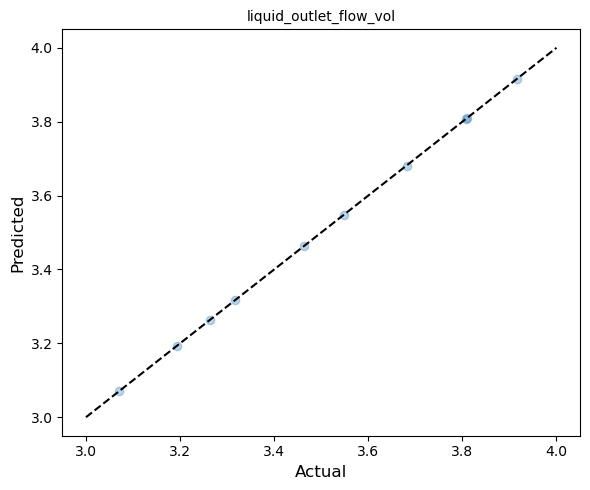

R2 training: 0.9999981228529734
MSE training: 1.441745309740859e-07
RMSE training: 0.00037970321433204366


In [11]:
# Applying the SR_model function to each pair of values
y_pred = np.array([SR_model(X[i,0], X[i,1]) for i in range(len(X))])
#print(y_pred)

# Stack the actual and predicted values column-wise
predicted_train = np.column_stack((y, y_pred))
# Save the numpy array to a CSV file
np.savetxt(f'train_results_{k}_{output_name}.csv', 
           predicted_train, delimiter=',', header=f'{output_name},{output_name}_pred', comments='', fmt='%f')

#Plot the training parity plot
z=[3,4]
w=[3,4]
fig, ax= plt.subplots(figsize=(6, 5))
ax.scatter(y, y_pred, alpha=0.3) 
ax.plot(z,w, 'k--') #y=x line
ax.set_xlabel('Actual', fontsize=12)
ax.set_ylabel('Predicted', fontsize=12)
ax.set_title(f'{output_name}', fontsize=10)
plt.tight_layout()
plt.savefig(f'parity_train_{output_name}_{k}.png', format='png')  # Save plot as a PNG file
plt.show()
plt.close(fig)  # Close the figure to free memory

r2_train = r2_score(y,y_pred)
print(f'R2 training: {r2_train}')

mse_train = mean_squared_error(y,y_pred)
print(f'MSE training: {mse_train}')

rmse_train = sqrt(mse_train)
print(f'RMSE training: {rmse_train}')   

#### Step 4: Read the csv file with the testing set

In [12]:
columns = ['liquid_inlet_conc_mol_comp_H2SO4','solid_inlet_flow_mass',
           f'{output_name}'] 

# read in our csv testing data
df_testing = pd.read_csv('3_4_simulation_data_1000_test.csv', usecols=columns)

# separate the data into inputs and outputs
inputs = ['liquid_inlet_conc_mol_comp_H2SO4','solid_inlet_flow_mass']

actual_outputs= [f'{output_name}']

dfin_testing = df_testing[inputs]
dfout_testing = df_testing[actual_outputs]

#Convert the pandas dataframes to numpy arrays
X_test = dfin_testing.to_numpy()
y_test = dfout_testing.to_numpy()

#scaler = MinMaxScaler((3,4))
#X_test = scaler.fit_transform(X_test)
#y_test = scaler.fit_transform(y_test.reshape(-1, 1))

#### Step 5: Predict $\hat{y}$ values for the testing set using the SR surrogate model

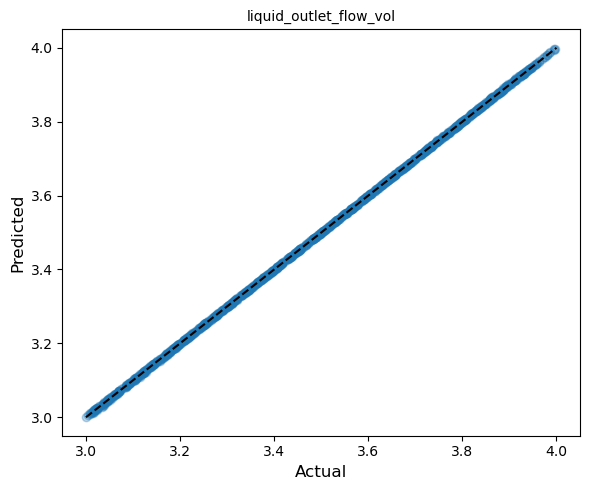

R2 test: 0.9999879823999711
MSE test: 9.185751764877862e-07
RMSE test: 0.000958423276265652


In [13]:
# Applying the SR_model function to each pair of values
y_pred_test = np.array([SR_model(X_test[i,0], X_test[i,1]) for i in range(len(X_test))])

# Stack the actual and predicted values column-wise
predicted_test = np.column_stack((y_test, y_pred_test))
# Save the numpy array to a CSV file
np.savetxt(f'test_results_{k}_{output_name}.csv', 
           predicted_test, delimiter=',', header=f'{output_name},{output_name}_pred', comments='', fmt='%f')

#Plot the training parity plot
z=[3,4]
w=[3,4]
fig, ax= plt.subplots(figsize=(6, 5))
ax.scatter(y_test, y_pred_test, alpha=0.3) 
ax.plot(z,w, 'k--') #y=x line
ax.set_xlabel('Actual', fontsize=12)
ax.set_ylabel('Predicted', fontsize=12)
ax.set_title(f'{output_name}', fontsize=10)
plt.tight_layout()
plt.savefig(f'parity_test_{output_name}_{k}.png', format='png')  # Save plot as a PNG file
plt.show()
plt.close(fig)  # Close the figure to free memory

r2_test = r2_score(y_test,y_pred_test)
print(f'R2 test: {r2_test}')

mse_test = mean_squared_error(y_test,y_pred_test)
print(f'MSE test: {mse_test}')

rmse_test = sqrt(mse_test)
print(f'RMSE test: {rmse_test}')   